# 第4章　TensorFlow编程基础

## 4.3　共享变量

下面来到本章的重点——共享变量。共享变量在复杂的网络中用处非常之广泛，所以读者一定要学好。

### 什么是变量

官网介绍见链接https://tensorflow.google.cn/guide/variables

其实变量的作用在语言中相对都有存储一些临时值的作用或者长久存储。在Tensorflow中当训练模型时，用变量来存储和更新参数。变量包含张量（Tensor）存放于内存的缓存区。建模时它们需要被明确地初始化，模型训练后它们必须被存储到磁盘。值可在之后模型训练和分析是被加载。

换句话说，Variables变量是通过张量进行初始化得到的。不像Tensor的值不可变，变量的值是可变的。

### 什么是共享变量

当我们有一个非常庞大的模型的时候免不了需要进行大量的变量共享，而且有时候还希望能够在一个地方初始化所有的变量，这就需要tf.variable_scope() 和 tf.get_variable()。 

## 4.3.1　共享变量用途

在构建模型时，需要使用tf.Variable来创建一个变量（也可以理解成节点）。例如代码：

biases = tf.Variable(tf.zeros([2]), name=" biases")     #创建一个偏执的学习参数，在训练时，这个变量不断地更新

但在某种情况下，一个模型需要使用其他模型创建的变量，两个模型一起训练。比如，对抗网络中的生成器模型与判别器模型（后文12章会有详细讲解）。如果使用tf.Variable，将会生成一个新的变量，而我们需要的是原来的那个biases变量。这时怎么办呢？这时就是通过引入get_variable方法，实现共享变量来解决这个问题。这个种方法可以使用多套网络模型来训练一套权重。

## 4.3.2　使用get-variable获取变量

get_variable一般会配合variable_scope一起使用，以实现共享变量。variable_scope的意思是变量作用域。在某一作用域中的变量可以被设置成共享的方式，被其他网络模型使用。后文的4.3.4节中会有共享变量的实例。下面先介绍下get_variable的详细使用。

get_variable函数的定义如下：

tf.get_variable(< name >, < shape >,< initializer >)
    
在TensorFlow里，使用 get_variable生成的变量是以指定的name属性为唯一标识，并不是定义的变量名称。使用时一般通过name属性定位到具体变量，并将其共享到其他模型中。

下面通过两个例子来深入介绍。

## 4.3.3　实例14：演示get_variable和Variable的区别

## 实例描述

分别使用Variable定义变量和使用get_variable来定义变量。请读者仔细观察它们的用法区别。

### 1．Variable的用法

首先先来看一下Variable的用法。

In [1]:
#代码4-9　get_variable和Variable的区别
import tensorflow as tf

var1 = tf.Variable(1.0 , name='firstvar')
print ("var1:",var1.name)
var1 = tf.Variable(2.0 , name='firstvar')
print ("var1:",var1.name)
var2 = tf.Variable(3.0 )
print ("var2:",var2.name)
var2 = tf.Variable(4.0 )
print ("var1:",var2.name)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("var1=",var1.eval())
    print("var2=",var2.eval())

Instructions for updating:
Colocations handled automatically by placer.
var1: firstvar:0
var1: firstvar_1:0
var2: Variable:0
var1: Variable_1:0
var1= 2.0
var2= 4.0


上面代码中定义了两次var1，可以看到在内存中生成了两个var1（因为它们的name不一样），对于图来讲后面的var1是生效的（var1=2.0）。

var2表明了：Variable定义时没有指定名字，系统会自动给加上一个名字Variable：0。

### 2．get_variable用法演示

接着上面的代码，使用get_variable添加get_var1变量。

In [2]:
#代码4-9　get_variable和Variable的区别（续）
import tensorflow as tf

var1 = tf.Variable(1.0 , name='firstvar')
print ("var1:",var1.name)
var1 = tf.Variable(2.0 , name='firstvar')
print ("var1:",var1.name)
var2 = tf.Variable(3.0 )
print ("var2:",var2.name)
var2 = tf.Variable(4.0 )
print ("var1:",var2.name)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("var1=",var1.eval())
    print("var2=",var2.eval())
    get_var1 = tf.get_variable("firstvar",[1], initializer=tf.constant_initializer(0.3))
    print("get_var1:", get_var1.name)
                           
    get_var1 = tf.get_variable("firstvar",[1], initializer=tf.constant_initializer(0.4))
    print("get_var1:", get_var1.name)

var1: firstvar_2:0
var1: firstvar_3:0
var2: Variable_2:0
var1: Variable_3:0
var1= 2.0
var2= 4.0
get_var1: firstvar_4:0


ValueError: Variable firstvar already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "E:\adaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()
  File "E:\adaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "E:\adaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)


可以看到，程序在定义第2个get_var1时发生崩溃了。这表明，使用get_variable只能定义一次指定名称的变量。同时由于变量firstvar在前面使用Variable函数生成过一次，所以系统自动变成了firstvar_2：0。

如果将崩溃的句子改成下面的样子：

In [4]:
#代码4-9　get_variable和Variable的区别（续）
import tensorflow as tf

var1 = tf.Variable(1.0 , name='firstvar')
print ("var1:",var1.name)
var1 = tf.Variable(2.0 , name='firstvar')
print ("var1:",var1.name)
var2 = tf.Variable(3.0 )
print ("var2:",var2.name)
var2 = tf.Variable(4.0 )
print ("var1:",var2.name)

get_var1 = tf.get_variable("firstvar",[1], initializer=tf.constant_initializer(0.3))
print("get_var1:", get_var1.name)

get_var1 = tf.get_variable("firstvar1",[1], initializer=tf.constant_initializer(0.4))
print("get_var1:", get_var1.name)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("get_var1=",get_var1.eval())

var1: firstvar:0
var1: firstvar_1:0
var2: Variable:0
var1: Variable_1:0
get_var1: firstvar_2:0
get_var1: firstvar1:0
get_var1= [0.4]


可以看到，这次仍然是又定义了一个get_var1，不同的是改变了它的名字firstvar1，这样就没有问题了。同样，新的get_var1会在图中生效，所以它的输出值是4.0而不是3.0。

## 4.3.4　实例15：在特定的作用域下获取变量

## 实例描述

在作用域下，使用get_variable，以及嵌套variable_scope。在前面的例子中，大家已经知道使用get_variable创建两个同样名字的变量是行不通的，如下代码会报错。

var1 = tf.get_variable("firstvar",shape=[2],dtype=tf.float32)

var2 = tf.get_variable("firstvar",shape=[2],dtype=tf.float32)

如果真想要那么做，可以使用variable_scope将它们隔开，代码如下：

In [1]:
#代码4-10　get_variable配合variable_scope
import tensorflow as tf
with tf.variable_scope("test1", ):     #定义一个作用域test1
    var1 = tf.get_variable("firstvar",shape=[2],dtype=tf.float32)
    
with tf.variable_scope("test2", ): 
    var2 = tf.get_variable("firstvar",shape=[2],dtype=tf.float32)
    
print ("var1:",var1.name)
print ("var2:",var2.name)

Instructions for updating:
Colocations handled automatically by placer.
var1: test1/firstvar:0
var2: test2/firstvar:0


var1和var2都使用firstvar的名字来定义。通过输出可以看出，其实生成的两个变量var1和var2是不同的，它们作用在不同的scope下，这就是scope的作用。

scope还支持嵌套，将上面代码中的第二个scope缩进一下，得到如下代码：

In [15]:
#代码4-11　get_variable配合variable_scope2
import tensorflow as tf
with tf.variable_scope("test1", ):     #定义一个作用域test1
    var1 = tf.get_variable("firstvar",shape=[2],dtype=tf.float32)
    
    with tf.variable_scope("test2", ): 
        var2 = tf.get_variable("firstvar",shape=[2],dtype=tf.float32)
    
print ("var1:",var1.name)
print ("var2:",var2.name)

var1: test1/firstvar:0
var2: test1/test2/firstvar:0


## 4.3.5　实例16：共享变量功能的实现

## 实例描述

使用作用域中的reuse参数来实现共享变量功能。费了这么大的劲来使用get_variable，目的其实是为了要通过它实现共享变量的功能。

variable_scope里面有个reuse=True属性，表示使用已经定义过的变量。这时get_variable将不会再创建新的变量，而是去图（一个计算任务）中get_variable所创建过的变量中找与name相同的变量。

在上文代码中再建立一个同样的scope，并且设置reuse=True，实现共享firstvar变量。

In [16]:
#代码4-11　get_variable配合variable_scope2（续）
with tf.variable_scope("test1",reuse=True ):
    var3= tf.get_variable("firstvar",shape=[2],dtype=tf.float32)
    with tf.variable_scope("test2"):
        var4 = tf.get_variable("firstvar",shape=[2],dtype=tf.float32)
        
print ("var3:",var3.name)
print ("var4:",var4.name)

var3: test1/firstvar:0
var4: test1/test2/firstvar:0


var1和var3的输出名字是一样的，var2和var4的名字也是一样的。这表明var1和var3共用了一个变量，var2和var4共用了一个变量，这就实现了共享变量。在实际应用中，可以把var1和var2放到一个网络模型里去训练，把var3和var4放到另一个网络模型里去训练，而两个模型的训练结果都会作用于一个模型的学习参数上。

注意： 如果读者使用的是Anaconda工具包里面的Spyder工具（第2章介绍过）运行，该代码只能运行一次，第二次会报错

解决办法：需要在Anacondad的Consoles菜单里退出当前的kernel，再重新进入一下。再运行才不会报错。否则会提示已经有这个变量了。

为什么会这样呢？

tf.get_variable在创建变量时，会去检查图（一个计算任务）中是否已经创建过该变量。如果创建过并且本次调用时没有被设为共享方式，则会报错。

明白原理后可以加一条语句tf.reset_default_graph（），将图（一个计算任务）里面的变量清空，就可以解决这个问题了。图（一个计算任务）的更多内容将在后面章节介绍。

## 4.3.6　实例17：初始化共享变量的作用域

## 实例描述

演示variable_scope中get_variable初始化的继承功能，以及嵌套variable_scope的继承功能。variable_scope和get_variable都有初始化的功能。在初始化时，如果没有对当前变量初始化，则TensorFlow会默认使用作用域的初始化方法对其初始化，并且作用域的初始化方法也有继承功能。下面演示代码。

In [1]:
#代码4-12　共享变量的作用域与初始化
import tensorflow as tf

with tf.variable_scope("test1", initializer=tf.constant_initializer(0.4)):
    var1 = tf.get_variable("firstvar",shape=[2],dtype=tf.float32)
    
    with tf.variable_scope("test2"):
        var2 = tf.get_variable("firstvar",shape=[2],dtype=tf.float32)
        var3 = tf.get_variable("test3", shape=[2],initializer=tf.constant_initializer(0.3))
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print ("var1=",var1.eval())         #作用域test1下的变量
    print ("var2=",var2.eval())         #作用域test2下的变量，继承test1初始化
    print ("var3=",var3.eval())         #作用域test3下的变量

Instructions for updating:
Colocations handled automatically by placer.
var1= [0.4 0.4]
var2= [0.4 0.4]
var3= [0.3 0.3]


上述代码大致操作如下：

·将test1作用域进行初始化为4.0，见代码第3行。

·var1没有初始化，见代码第4行。

·嵌套的test2作用域也没有初始化，见代码第6行。

·test2下的var3进行了初始化，见代码第8行。

var1数组值为0.4，表明继承了test1的值；var2数组值为0.4，表明其所在的作用域test2也继承了test1的初始化；变量var3在创建时同步指定了初始化操作，所以数组值为0.3。

注意：在多模型训练中，常常会使统一为学习参数进行默认的初始化。同时，统一为学习参数进行默认的初始化。在变量共享方面，还可以使用tf.AUTO_REUSE来为reuse属性赋值。tf.AUTO_REUSE可以实现第一次调用ariable_scope时，传入的reuse值是False；再次调用variable_scope时，传入reuse的值就会自动变为True。

## 4.3.7　实例18：演示作用域与操作符的受限范围

## 实例描述

演示variable_scope的as用法，以及对应的作用域。

variable_scope还可以使用with variable_scope（"name"）as xxxscope的方式定义作用域，当使用这种方式时，所定义的作用域变量xxxscope将不再受到外围的scope所限制。看下面的例子。

In [1]:
#代码4-13　作用域与操作符的受限范围
import tensorflow as tf

with tf.variable_scope("scope1") as sp:
     var1 = tf.get_variable("v", [1])

print("sp:",sp.name)              #作用域名称 
print("var1:",var1.name)      

with tf.variable_scope("scope2"):
    var2 = tf.get_variable("v", [1])
    
    with tf.variable_scope(sp) as sp1:
        var3 = tf.get_variable("v3", [1])
          
print("sp1:",sp1.name)  
print("var2:",var2.name)
print("var3:",var3.name)

Instructions for updating:
Colocations handled automatically by placer.
sp: scope1
var1: scope1/v:0
sp1: scope1
var2: scope2/v:0
var3: scope1/v3:0


例子中定义了作用域scope1 as sp（见代码第3行），然后将sp放在作用域scope2中，并as成sp1（见代码第12行）。

sp和var1的输出前面已经交代过。sp1在scope2下，但是输出仍是scope1，没有改变。在它下面定义的var3的名字是scope1/v3：0，表明也在scope1下，再次说明sp没有受到外层的限制。

另外再介绍一个操作符的作用域tf.name_scope，如下所示。操作符不仅受到tf.name_scope作用域的限制，同时也受到tf.variable_scope作用域的限制。

In [3]:
#代码4-13　作用域与操作符的受限范围（续）
with tf.variable_scope("scope"):
    with tf.name_scope("bar"):
        v = tf.get_variable("v", [1])        #v为一个变量
        x = 1.0 + v                          # x为一个op
print("v:",v.name)  
print("x.op:",x.op.name)

v: scope/v:0
x.op: scope/bar/add


可以看到，虽然v和x都在scope的bar下面，但是v的命名只受到scope的限制，tf.name_scope只能限制op，不能限制变量的命名。

在tf.name_scope函数中，还可以使用空字符将作用域返回到顶层。

下面举例来比较tf.name_scope与variable_scope在空字符情况下的处理：

·在代码第28行var3的定义之后添加空字符的variable_scope。

·定义var4，见代码第31行。

在x = 1.0 + v之后添加空字符的tf.name_scope，并定义y。代码如下：

In [1]:
#代码4-13　作用域与操作符的受限范围（续）

import tensorflow as tf

with tf.variable_scope("scope1") as sp:
     var1 = tf.get_variable("v", [1])

with tf.variable_scope("scope2"):
    var2 = tf.get_variable("v", [1])
    
    with tf.variable_scope(sp) as sp1:
        var3 = tf.get_variable("v3", [1])
                   
        with tf.variable_scope("") :
            var4 = tf.get_variable("v4", [1])

print("var4:",var4.name)

Instructions for updating:
Colocations handled automatically by placer.
var4: scope1//v4:0


In [1]:
#代码4-13　作用域与操作符的受限范围（续）

import tensorflow as tf

with tf.variable_scope("scope1") as sp:
     var1 = tf.get_variable("v", [1])

with tf.variable_scope("scope2"):
    var2 = tf.get_variable("v", [1])
    
    with tf.variable_scope(sp) as sp1:
        var3 = tf.get_variable("v3", [1])
   
        with tf.variable_scope("scope"):
            with tf.name_scope("bar"):
                v = tf.get_variable("v", [1])
                x = 1.0 + v
                with tf.name_scope(""):
                     y = 1.0 + v

print("y.op:",y.op.name)

Instructions for updating:
Colocations handled automatically by placer.
y.op: add


可以看到，y变成顶层了，而var4多了一个空层。

## 4.4　实例19：图的基本操作

前面接触了一些图（一个计算任务）的概念，这里来系统地了解一下TensorFlow中的图可以做哪些事情。

## 实例描述

（1）本例演示使用3种方式来建立图，并依次设置为默认图，使用get_default_graph（）方法来获取当前默认图，验证默认图的设置生效。

（2）演示获取图中相关内容的操作。一个TensorFlow程序默认是建立一个图的，除了系统自动建图以外，还可以手动建立，并做一些其他的操作。

## 4.4.1　建立图

可以在一个TensorFlow中手动建立其他的图，也可以根据图里的变量获得当前的图。下面代码演示了使用tf.Graph函数建立图，使用tf.get_default_graph函数获得图，以及使用reset_default_graph的过程来重置图的过程。

In [18]:
#代码4-14　图的基本操作
import numpy as np
import tensorflow as tf 
c = tf.constant(0.0)

g = tf.Graph()
with g.as_default():
    c1 = tf.constant(0.0)
    print(c1.graph)
    print(g)
    print(c.graph)

g2 =  tf.get_default_graph()
print(g2)

tf.reset_default_graph()
g3 =  tf.get_default_graph()
print(g3)

可以看出。

（1）c是在刚开始的默认图中建立的，所以图的打印值就是原始的默认图的打印值24ED62B6E48。

（2）然后使用tf.Graph函数建立了一个图24EDB2EB518（见代码第5行），并且在新建的图里添加变量，可以通过变量的“.graph”获得所在的图。

（3）在新图24EDB2EB518的作用域外，使用tf.get_default_graph函数又获得了原始的默认图24ED62B6E48（见代码第12行）。接着又使用tf.reset_default_graph函数（见代码第15行），相当于重新建了一张图来代替原来的默认图，这时默认的图变成了24EDB2EB940。

 注意： 在使用tf.reset_default_graph函数时必须保证当前图的资源已经全部释放，否则会报错。例如，在当前图中使用tf.InteractiveSession函数建立了一个会话，在会话结束时却没有调用close进行关闭，那么再执行tf.reset_default_graph函数时，就会报错。
 
## 4.4.2　获取张量

在图里面可以通过名字得到其对应的元素，例如，get_tensor_by_name可以获得图里面的张量。在上个实例中添加如下代码。

In [19]:
#代码4-14　图的基本操作（续）
print(c1.name)
t = g.get_tensor_by_name(name = "Const:0")
print(t)

Const:0
Tensor("Const:0", shape=(), dtype=float32)


常量c1是在一个子图g中建立的。withtf.Graph（） as default代码表示使用tf.Graph函数来创建一个图，并在其上面定义OP，见代码第5、6行。

接着演示了如何访问该图中的变量：将c1的名字放到get_tensor_by_name里来反向得到其张量（见代码第19行），通过对t的打印可以看到所得的t就是前面定义的张量c1。

注意： 不必花太多精力去关注TensorFlow中默认的命名规则。一般在需要使用名字时，都会在定义的同时为它指定好固定的名字。如果真的不清楚某个元素的名字，可将其打印出来，回填到代码中，再次运行即可。

## 4.4.3　获取节点操作

获取节点操作OP的方法和获取张量的方法非常类似，使用的方法是get_operation_ by_name。下面将获取张量和获取OP的例子放在一起比较一下，具体代码如下。

In [20]:
#代码4-14　图的基本操作（续）
a = tf.constant([[1.0, 2.0]])
b = tf.constant([[1.0], [3.0]])

tensor1 = tf.matmul(a, b, name='exampleop')
print(tensor1.name,tensor1) 
test = g3.get_tensor_by_name("exampleop:0")
print(test)

print(tensor1.op.name)
testop = g3.get_operation_by_name("exampleop")
print(testop)

with tf.Session() as sess:
    test =  sess.run(test)
    print(test) 
    test = tf.get_default_graph().get_tensor_by_name("exampleop:0")
    print(test)

exampleop:0 Tensor("exampleop:0", shape=(1, 1), dtype=float32)
Tensor("exampleop:0", shape=(1, 1), dtype=float32)
exampleop
name: "exampleop"
op: "MatMul"
input: "Const"
input: "Const_1"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "transpose_a"
  value {
    b: false
  }
}
attr {
  key: "transpose_b"
  value {
    b: false
  }
}

[[7.]]
Tensor("exampleop:0", shape=(1, 1), dtype=float32)


上面示例中，先将张量及其名字打印出来，然后使用g3图的get_tensor_by_name函数又获得了该张量，此时test和tensor1是一样的。为了证明这一点，直接把test放到session的run里，发现它运行后也能得到正确的结果。

注意： 使用默认的图时，也可以用上述代码中的tf.get_default_graph函数获取当前图，然后可以调用get_tensor_by_name函数获取元素。

再仔细看上例中的OP，通过打印tensor1.op.name的信息，获得了OP的名字，然后通过get_operation_by_name函数获得了相同的OP，可以看出OP与tensor1之间的对应关系。

 注意： 这里之所以要放在一起举例，原因就是OP和张量在定义节点时很容易被混淆。上例中的tensor1 = tf.matmul（a，b，name='exampleop'）并不是OP，而是张量。OP其实是描述张量中的运算关系，是通过访问张量的属性找到的。
 
## 4.4.4　获取元素列表

如果想看一下图中的全部元素，可以使用get_operations函数来实现。具体代码如下。

In [21]:
#代码4-14　图的基本操作（续）
tt2 = g.get_operations()
print(tt2)

[<tf.Operation 'Const' type=Const>]


由于g里面只有一个常量，所以打印了一条信息。

## 4.4.5　获取对象

前面是根据名字来获取元素，还可以根据对象来获取元素。使用tf.Graph.as_graph_element（obj，allow_tensor=True，allow_operation=True）函数，即传入的是一个对象，返回一个张量或是一个OP。该函数具有验证和转换功能，在多线程方面会偶尔用到。举例如下。

In [22]:
#代码4-14　图的基本操作（续）
tt3 = g.as_graph_element(c1)
print(tt3)

Tensor("Const:0", shape=(), dtype=float32)


上述代码通过对tt3的打印可以看到，变量tt3所指的张量名字为Const0，而在4.4.2节中可以看到量名c1所指向的真实张量名字也为Const0。这表明：函数as_graph_element 获得了c1的真实张量对象，并赋给了变量tt3。

 备注： 这里只是介绍了图中比较简单的操作，图的操作还有很多，有的还很常用。但考虑到初学者的接受程度，更复杂的图操作（如冻结图，将一个图导入另一个图中等）将会在后面的章节中进行介绍。
 
## 4.4.6　练习题

试试将tf.get_default_graph函数放在with tf.Graph（）.as_default（）：作用域里，看看会得到什么，是全局的默认图，还是tf.Graph函数新建的图？（示例代码在“代码4-14图的基本操作”中）

In [7]:
import numpy as np
import tensorflow as tf 
c = tf.constant(0.0)

g = tf.Graph()

with tf.Graph().as_default():
    c1 = tf.constant(0.0)
    print(c1.graph)
    print(g)
    print(c.graph)

g2 =  tf.get_default_graph()
print(g2)

tf.reset_default_graph()
g3 =  tf.get_default_graph()
print(g3)

c1与c不同，由此可以看出并非全局默认图，是tf.Graph函数新建的图。

# 4.5　配置分布式TensorFlow

在大型的数据集上进行神经网络的训练，往往需要更大的运算资源，而且还要耗费若干天才能完成运算量。

TensorFlow提供了一个可以分布式部署的模式，将一个训练任务拆成多个小任务，分配到不同的计算机上来完成协同运算，这样使用计算机群运算来代替单机计算，可以使训练时间大大缩短。

## 4.5.1　分布式TensorFlow的角色及原理

要想配置TensorFlow为分布训练，需要先了解TensorFlow中关于分布式的角色分配。

·ps：作为分布式训练的服务端，等待各个终端（supervisors）来连接。

·worker：在TensorFlow的代码注释中被称为supervisors，作为分布式训练的运算终端。

·chief supervisors：在众多运算终端中必须选择一个作为主要的运算终端。该终端是在运算终端中最先启动的，它的功能是合并各个终端运算后的学习参数，将其保存或载入。

每个具体角色网络标识都是唯一的，即分布在不同IP的机器上（或者同一个机但不同的端口）。

在实际运行中，各个角色的网络构建部分代码必须100%的相同。三者的分工如下：

·服务端作为一个多方协调者，等待各个运算终端来连接。

·chief supervisors会在启动时统一管理全局的学习参数，进行初始化或从模型载入。

·其他的运算终端只是负责得到其对应的任务并进行计算，并不会保存检查点，用于TensorBoard可视化中的summary日志等任何参数信息。

整个过程都是通过RPC协议来通信的。

## 4.5.2　分布部署TensorFlow的具体方法

配置过程中，首先需要建一个server，在server中会将ps及所有worker的IP端口准备好。接着，使用tf.train.Supervisor中的managed_session来管理一个打开的session。session中只是负责运算，而通信协调的事情就都交给supervisor来管理了。

## 4.5.3　实例20：使用TensorFlow实现分布式部署训练

下面开始实现一个分布式训练的网络模型。本例以“代码4-8线性回归的TensorBoard可视化.py”为原型，在其中添加代码将其改成分布式。

## 实例描述

在本机通过3个端口来建立3个终端，分别是一个ps，两个worker，实现TensorFlow的分布式运算。

具体步骤如下。

1．为每个角色添加IP地址和端口，创建server

在一台机器上开3个不同的端口，分别代表ps、chief supervisors 和worker。角色的名称用strjob_name表示。以ps为例，代码如下：

In [1]:
#代码4-15　ps
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

#定义IP和端口 
strps_hosts="localhost:1681"
strworker_hosts="localhost:1682,localhost:1683"

#定义角色名称
strjob_name = "ps"
task_index = 0
#将字符串转成数组
ps_hosts = strps_hosts.split(',')
worker_hosts = strworker_hosts.split(',')
cluster_spec = tf.train.ClusterSpec({'ps': ps_hosts,'worker': worker_hosts})
server = tf.train.Server({'ps': ps_hosts,'worker': worker_hosts}, job_name=strjob_name, task_index=task_index)

#定义占位符
train_X = np.linspace(-1, 1, 100)
train_Y = 2 * train_X + np.random.randn(*train_X.shape) * 0.3      # y=2x 但是加入了噪声 

# 创建模型
# 占位符
X = tf.placeholder("float")
Y = tf.placeholder("float") 
# 模型参数
W = tf.Variable(tf.random_normal([1]), name="weight")
b = tf.Variable(tf.zeros([1]), name="bias") 
# 占位符
X = tf.placeholder("float")
Y = tf.placeholder("float") 
# 模型参数
W = tf.Variable(tf.random_normal([1]), name="weight")
b = tf.Variable(tf.zeros([1]), name="bias") 
# 前向结构
z = tf.multiply(X, W) + b 
# 将预测值以直方图形式显示
tf.summary.histogram('z', z) 
# 反向优化
cost = tf.reduce_mean(tf.square(Y - z)) 
# 将损失以标量形式显示
tf.summary.scalar('loss_function', cost)
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) 
# 初始化所有变量
init = tf.global_variables_initializer() 
# 定义参数
trainning_epochs = 20
display_step = 2 
# 启动session
with tf.Session() as sess:    
    sess.run(init)    
    plotdata = {"batchsize":[], "loss":[]}    
    # 合并所有summary    
    merged_summary_op = tf.summary.merge_all()    
    # 创建summary_writter 用于写文件    
    summary_writter = tf.summary.FileWriter('log/mnist_with_summaries', sess.graph)
    # 存放批次值和损失值    
    # 向模型输入数据    
    for epoch in range(trainning_epochs):        
        for(x, y) in zip(train_X, train_Y):            
            sess.run(optimizer, feed_dict={X:x, Y:y})        
        summary_str = sess.run(merged_summary_op, feed_dict={X: x, Y: y})        
            # 将summary写入文件        
        summary_writter.add_summary(summary_str, epoch)        
            # 显示训练中的详细信息        
        if epoch % display_step == 0:            
            loss = sess.run(cost, feed_dict={X:train_X, Y:train_Y})            
            print("Epoch:", epoch + 1, "cost=", loss, "W=", sess.run(W), "b=", sess.run(b))            
            if not (loss == "NA"):                
                plotdata["batchsize"].append(epoch)                
                plotdata["loss"].append(loss)    
    print(" Finished")   
    print("cost=", sess.run(cost, feed_dict={X:train_X, Y:train_Y}), "W=", sess.run(W), "b=", sess.run(b))    
#测试
    print("x=0.2, z=", sess.run(z, feed_dict={X: 0.2}))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch: 1 cost= 0.244577 W= [1.3856312] b= [0.2529116]
Epoch: 3 cost= 0.11496342 W= [1.8175545] b= [0.14746909]
Epoch: 5 cost= 0.10478575 W= [1.9357979] b= [0.10310863]
Epoch: 7 cost= 0.10434034 W= [1.966482] b= [0.09135079]
Epoch: 9 cost= 0.10437437 W= [1.9744174] b= [0.08830591]
Epoch: 11 cost= 0.10439314 W= [1.9764694] b= [0.08751843]
Epoch: 13 cost= 0.10439867 W= [1.9770001] b= [0.08731481]
Epoch: 15 cost= 0.10440015 W= [1.9771371] b= [0.08726224]
Epoch: 17 cost= 0.10440052 W= [1.9771725] b= [0.08724864]
Epoch: 19 cost= 0.104400635 W= [1.977182] b= [0.08724503]
 Finished
cost= 0.10440066 W= [1.9771835] b= [0.08724441]
x=0.2, z= [0.48268113]


2.为ps角色添加等待函数

ps角色使用server.join()函数进行线程挂起，开始接受连接消息。

In [ ]:
#代码4-15　ps（续）
#ps角色处于监听状态，等待终端连接
if strjob_name == 'ps':
    print('waiting....')
    server.join()

waiting....


3.创建网络结构

与正常的程序不同，在创建网络结构时，使用tf.device()函数将全部的节点都放在当前任务下。

在rf.device()函数中的任务是通过tf.train.replica_device_setter()来指定的。

在tf.train.replica_device_setter()中使用worker_device()来定义具体任务名称:使用cluster的配置来指定角色和对应的ip地址，从而实现整个任务下的图节点。代码如下：

In [2]:
#代码4-15　ps（续）
with tf.device(tf.train.replica_device_setter(
        worker_device = '/job:worker/task:{0}'.format(task_index),
        cluster = cluster_spec)):
    
    #创建占位符
    X = tf.placeholder("float")
    Y = tf.placeholder("float")
    #模型参数
    W = tf.Variable(tf.truncated_normal([1]),name='weight')    #设置正太分布参数  初始化权重
    b = tf.Variable(tf.truncated_normal([1]),name='bias')    #设置正太分布参数  初始化偏置

    global_step = tf.train.get_or_create_global_step()
    
    #前向结构
    z = tf.multiply(X, W) + b
    
    #将预测值以直方图形式显示
    tf.summary.histogram('z',z)
    
    #定义代价函数  选取二次代价函数
    cost = tf.reduce_mean(tf.square(Y - z))
    
    #将损失以标量形式显示 该变量命名为loss_function
    tf.summary.scalar('loss_function',cost)
    learning_rate = 0.01
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost,global_step = global_step)
    
    saver = tf.train.Saver(max_to_keep = 1)
    
    merged_summary_op = tf.summary.merge_all()             #合并所有的summary
    
    #初始化所有变量，因此变量需要放在其前面定义
    init  =tf.global_variables_initializer()

为了使载入检查点文件能够同步循环次数，这里添加了一个global_step变量，将其放到优化器中。这样每运行一次优化器，global_step就会自动获得当期迭代的次数。

注意： init =tf.global_variables_initializer（）这个代码是将其前面的变量全部初始化，如果后面再有变量，则不会被初始化。所以，一般要将init = tf.global_variables_ initializer（）这个代码放在最后。这是个很容易出错的地方，常常令开发者找不到头绪。读者也可以试着在最前面运行，看看会发生什么。

4.创建Supervisor，管理session

In [ ]:
#代码4-15　ps（续）
# 定义参数
training_epochs = 2200
display_step = 2

sv = tf.train.Supervisor(is_chief=(task_index == 0),         #0号worker为chief
                         logdir="log/super/",
                         init_op=init,
                         summary_op=None,
                         saver=saver,
                         global_step=global_step,
                         save_model_secs=5)

#连接目标角色创建session
with sv.managed_session(server.target) as sess:
    print("sess ok")
    print(global_step.eval(session=sess))
    
    for epoch in range(global_step.eval(session=sess),training_epochs*len(train_X)):
   
        for (x, y) in zip(train_X, train_Y):
            _, epoch = sess.run([optimizer,global_step] ,feed_dict={X: x, Y: y});
            #生成summary
            summary_str = sess.run(merged_summary_op,feed_dict={X: x, Y: y});
            #将summary写入文件
            sv.summary_computed(sess,summary_str,global_step=epoch)
            if epoch % display_step == 0:    
                loss = sess.run(cost,feed_dict={X: train_X, Y: train_Y})
                print ("Epoch:", epoch+1, "cost=", loss, "W=", sess.run(W), "b=", sess.run(b))            
                if not (loss == "NA"):                
                    plotdata["batchsize"].append(epoch)
                    plotdata["loss"].append(loss)
                
    print (" Finished!")
    sv.saver.save(sess,"log/mnist_with_summaries/"+"sv.cpk", global_step=epoch)
              
sv.stop()

Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession


在tf.train.Supervisor函数中，is_chief表明了是否为chief supervisors角色。这里将task_index=0的worker设置成chief supervisors。logdir为检查点文件和summary文件保存的路径。

init_op表示使用初始化变量的函数。saver需要将保存检查点的saver对象传入，supervisor就会自动保存检查点文件。如果不想自动保存，可以设为None。

同理，summary_op也是自动保存summary文件。这里设为None，表示不自动保存。

save_model_secs为保存检查点文件的时间间隔。这里设为5，表示每5秒自动保存一次检查点文件。以上代码，为了让分布运算的效果明显一些，将迭代次数改成了2200，使其运算时间变长。

5．迭代训练

session中的内容与以前一样，直接迭代训练即可。由于使用了supervisor管理session，将使用sv.summary_computed函数来保存summary文件。同样，如想要手动保存检测点文件，也可以使用sv.saver.save。代码已在上面运行。

注意： （1）在设置自动保存检查点文件后，手动保存仍然有效。

（2）在运行一半后终止，再运行supervisor时会自动载入模型的参数，不需要手动调用saver.restore。

（3）在session中，不需要再运行tf.global_variables_initializer函数。原因是supervisor在建立时会调用传入的init_op进行初始化，如果加了sess.run（tf.global_ variables_initializer（）），则会导致所载入模型的变量被二次清空。

6．建立worker文件

将文件复制两份，分别起名为“4-16worker.py”与“4-17 worker2.py”，将角色名称修改成worker，并将“4-16 worker2.py”中的task_index设为1。

In [ ]:
#代码4-16　worker
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

#定义角色名称
strjob_name = "worker"
task_index = 0

#将字符串转成数组
ps_hosts = strps_hosts.split(',')
worker_hosts = strworker_hosts.split(',')
cluster_spec = tf.train.ClusterSpec({'ps': ps_hosts,'worker': worker_hosts})
server = tf.train.Server({'ps': ps_hosts,'worker': worker_hosts}, job_name=strjob_name, task_index=task_index)

#定义占位符
train_X = np.linspace(-1, 1, 100)
train_Y = 2 * train_X + np.random.randn(*train_X.shape) * 0.3      # y=2x 但是加入了噪声 

# 创建模型
# 占位符
X = tf.placeholder("float")
Y = tf.placeholder("float") 
# 模型参数
W = tf.Variable(tf.random_normal([1]), name="weight")
b = tf.Variable(tf.zeros([1]), name="bias") 
# 前向结构
z = tf.multiply(X, W) + b 
# 将预测值以直方图形式显示
tf.summary.histogram('z', z) 
# 反向优化
cost = tf.reduce_mean(tf.square(Y - z)) 
# 将损失以标量形式显示
tf.summary.scalar('loss_function', cost)
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) 
# 初始化所有变量
init = tf.global_variables_initializer() 
# 定义参数
trainning_epochs = 20
display_step = 2 
# 启动session
with tf.Session() as sess:    
    sess.run(init)    
    plotdata = {"batchsize":[], "loss":[]}    
    # 合并所有summary    
    merged_summary_op = tf.summary.merge_all()    
    # 创建summary_writter 用于写文件    
    summary_writter = tf.summary.FileWriter('log/mnist_with_summaries', sess.graph)
    # 存放批次值和损失值    
    # 向模型输入数据    
    for epoch in range(trainning_epochs):        
        for(x, y) in zip(train_X, train_Y):            
            sess.run(optimizer, feed_dict={X:x, Y:y})        
        summary_str = sess.run(merged_summary_op, feed_dict={X: x, Y: y})        
            # 将summary写入文件        
        summary_writter.add_summary(summary_str, epoch)        
            # 显示训练中的详细信息        
        if epoch % display_step == 0:            
            loss = sess.run(cost, feed_dict={X:train_X, Y:train_Y})            
            print("Epoch:", epoch + 1, "cost=", loss, "W=", sess.run(W), "b=", sess.run(b))            
            if not (loss == "NA"):                
                plotdata["batchsize"].append(epoch)                
                plotdata["loss"].append(loss)    
    print(" Finished")   
    print("cost=", sess.run(cost, feed_dict={X:train_X, Y:train_Y}), "W=", sess.run(W), "b=", sess.run(b))    
#测试
    print("x=0.2, z=", sess.run(z, feed_dict={X: 0.2}))

In [ ]:
#代码4-17　worker2

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

#定义角色名称
strjob_name = "worker"
task_index = 1

#将字符串转成数组
ps_hosts = strps_hosts.split(',')
worker_hosts = strworker_hosts.split(',')
cluster_spec = tf.train.ClusterSpec({'ps': ps_hosts,'worker': worker_hosts})
server = tf.train.Server({'ps': ps_hosts,'worker': worker_hosts}, job_name=strjob_name, task_index=task_index)

#定义占位符
train_X = np.linspace(-1, 1, 100)
train_Y = 2 * train_X + np.random.randn(*train_X.shape) * 0.3      # y=2x 但是加入了噪声 

# 创建模型
# 占位符
X = tf.placeholder("float")
Y = tf.placeholder("float") 
# 模型参数
W = tf.Variable(tf.random_normal([1]), name="weight")
b = tf.Variable(tf.zeros([1]), name="bias") 
# 前向结构
z = tf.multiply(X, W) + b 
# 将预测值以直方图形式显示
tf.summary.histogram('z', z) 
# 反向优化
cost = tf.reduce_mean(tf.square(Y - z)) 
# 将损失以标量形式显示
tf.summary.scalar('loss_function', cost)
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost) 
# 初始化所有变量
init = tf.global_variables_initializer() 
# 定义参数
trainning_epochs = 20
display_step = 2 
# 启动session
with tf.Session() as sess:    
    sess.run(init)    
    plotdata = {"batchsize":[], "loss":[]}    
    # 合并所有summary    
    merged_summary_op = tf.summary.merge_all()    
    # 创建summary_writter 用于写文件    
    summary_writter = tf.summary.FileWriter('log/mnist_with_summaries', sess.graph)
    # 存放批次值和损失值    
    # 向模型输入数据    
    for epoch in range(trainning_epochs):        
        for(x, y) in zip(train_X, train_Y):            
            sess.run(optimizer, feed_dict={X:x, Y:y})        
        summary_str = sess.run(merged_summary_op, feed_dict={X: x, Y: y})        
            # 将summary写入文件        
        summary_writter.add_summary(summary_str, epoch)        
            # 显示训练中的详细信息        
        if epoch % display_step == 0:            
            loss = sess.run(cost, feed_dict={X:train_X, Y:train_Y})            
            print("Epoch:", epoch + 1, "cost=", loss, "W=", sess.run(W), "b=", sess.run(b))            
            if not (loss == "NA"):                
                plotdata["batchsize"].append(epoch)                
                plotdata["loss"].append(loss)    
    print(" Finished")   
    print("cost=", sess.run(cost, feed_dict={X:train_X, Y:train_Y}), "W=", sess.run(W), "b=", sess.run(b))    
#测试
    print("x=0.2, z=", sess.run(z, feed_dict={X: 0.2}))

注意： 这个例子中使用了summary的一些方法将运行时态的数据保存起来，以便于使用TensorBoard进行查看（见4.1.16节）。但在分布式部署时，使用该功能还需要注意以下几点：

（1）不能使用sv.summary_computed，因为worker2不是chief supervisors，在worker2中是不会为supervisor对象构造默认summary_writer的（所有
的summary信息都要通过该对象进行写入），所以即使调用summary_computed也无法执行下去，程序会报错。

（2）手写控制summary与检查点文件保存时，需要将chief supervisors以外的worker全部去掉才可以。可以使用supervisor按时间间隔保存的形式来管理，这样用一套代码就可以解决了。

7．部署运行

（1）在Spyder中先将“4-15 ps.py”文件运行起来，选择菜单Consoles|Open an IPython console命令，新打开一个Consoles。

（2）在Spyder面板的右下角，可以看到在原有标题为“Console1/A”标签旁边又多了一个“Console 2/A”标签，单击该标签，使其处于激活状态。

（3）运行4-17 worker2.py文件。最后按照“4-17worker2.py”文件启动的方式，启动4-16worker.py”文件，这时3个窗口的显示内容分别如下：

·“4-16worker.py”文件对应窗口显示正常的训练信息。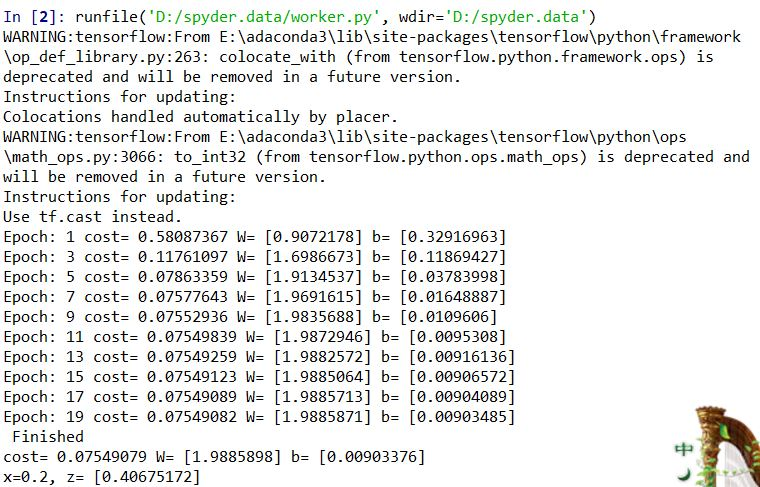

可以看到循环的次数并不是连续的，跳过的步骤被分配到worker2中去运算了

·“4-17worker2.py”文件对应窗口显示的信息如下：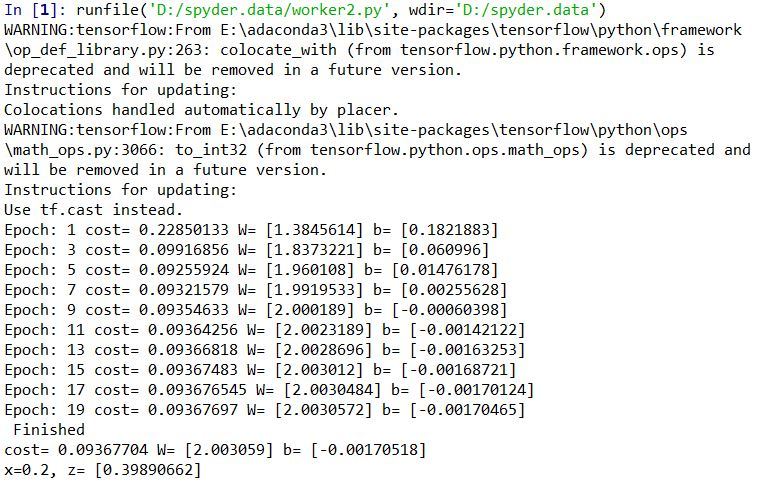

显示结果中有警告输出，这是因为在构建supervisor时没有填写local_init_op参数，该参数的意思是在创建worker实例时，初始化本地变量。由于例子中没有填，系统就会自动初始化，并给出警告提示。

从日志中可以看到worker2 与chief supervisors的迭代序号近似互补，为什么没有绝对互补呢？可能与supervisor中的同步算法有关。

分布运算目的是为了提高整体运算速度，如果同步epoch的准确度需要以牺牲总体运算速度为代价，自然很不合适。所以更合理的推断是因为单机单次的运算太快迫使算法使用了更宽松的同步机制。

重要的一点是对于指定步数的学习参数b和w是一致的（如第8040步，学习参数是相同的，都为W= [ 2.01313496] b= [ 0.01954099]），这表明两个终端是在相同的起点上进行运算的。

·对于4-15ps.py文件，其对应窗口则是一直静默着只显示打印的那句wait，因为它只负责连接不参与运算。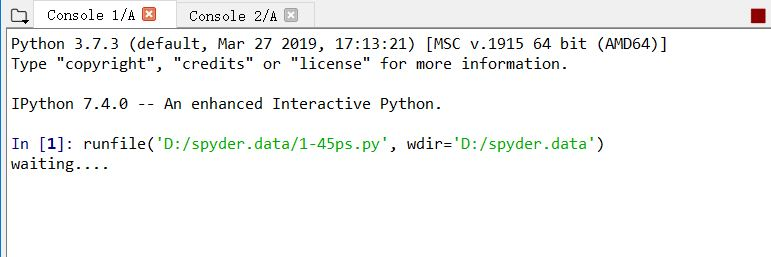

# 4.6　动态图（Eager）

动态图是相对于静态图而言的。所谓的动态图是指在Python中代码被调用后，其操作立即被执行的计算。其与静态图最大的区别是不需要使用session来建立会话了。即，在静态图中，需要在会话中调用run方法才可以获得某个张量的具体值；而在动态图中，直接运行就可以或得到具体值了。

动态图是在TensorFlow 1.3版本之后出现的。它使TensorFlow 的入门变得更简单，也使研发更直观。

启用动态图只需要在程序的最开始处加上两行代码：

In [ ]:
import tensorflow.contrib.eager as tfe
tfe.enable_eager_execution()

这两行代码的作用就是开启动态图计算功能。例如，调用tf.matmul时，将会立即计算两个数相乘的值，而不是一个op。

Eager还处于一个试用阶段，也是TensorFlow大力推广的新特性，未来或许会成为趋势。想了解更多内容，可以参考如下网址：https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager

在建立动态图的过程中，默认也建立了一个session。所有的代码都在该session中进行，而且该session具有进程相同的生命周期。这表明一旦使用动态图就无法实现静态图中关闭session的功能。这便是动态图的不足之处：无法实现多session操作。如果当前代码只需要一个session来完成的话，建议优先选择动态图Eager来实现。

# 4.7　数据集（tf.data）

TensorFlow中有3种数据输入模式：

·直接使用feed_dict利用注入模式进行数据输入（见4.1.4节），适用于少量的数据集输入；

·使用队列式管道（见11.5.3节），适用于大量的数据集输入；

·性能更高的输入管道，适用于TensorFlow1.4之后的版本，是为动态图（见4.6节）功能提供的大数据集输入方案（动态图的数据集输入只能使用该方法），当然也支持静态图。

关于第3种方式的更多介绍，请参考以下链接：https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/g3doc/guide.md#input-pipelines

# 本章总结
 
 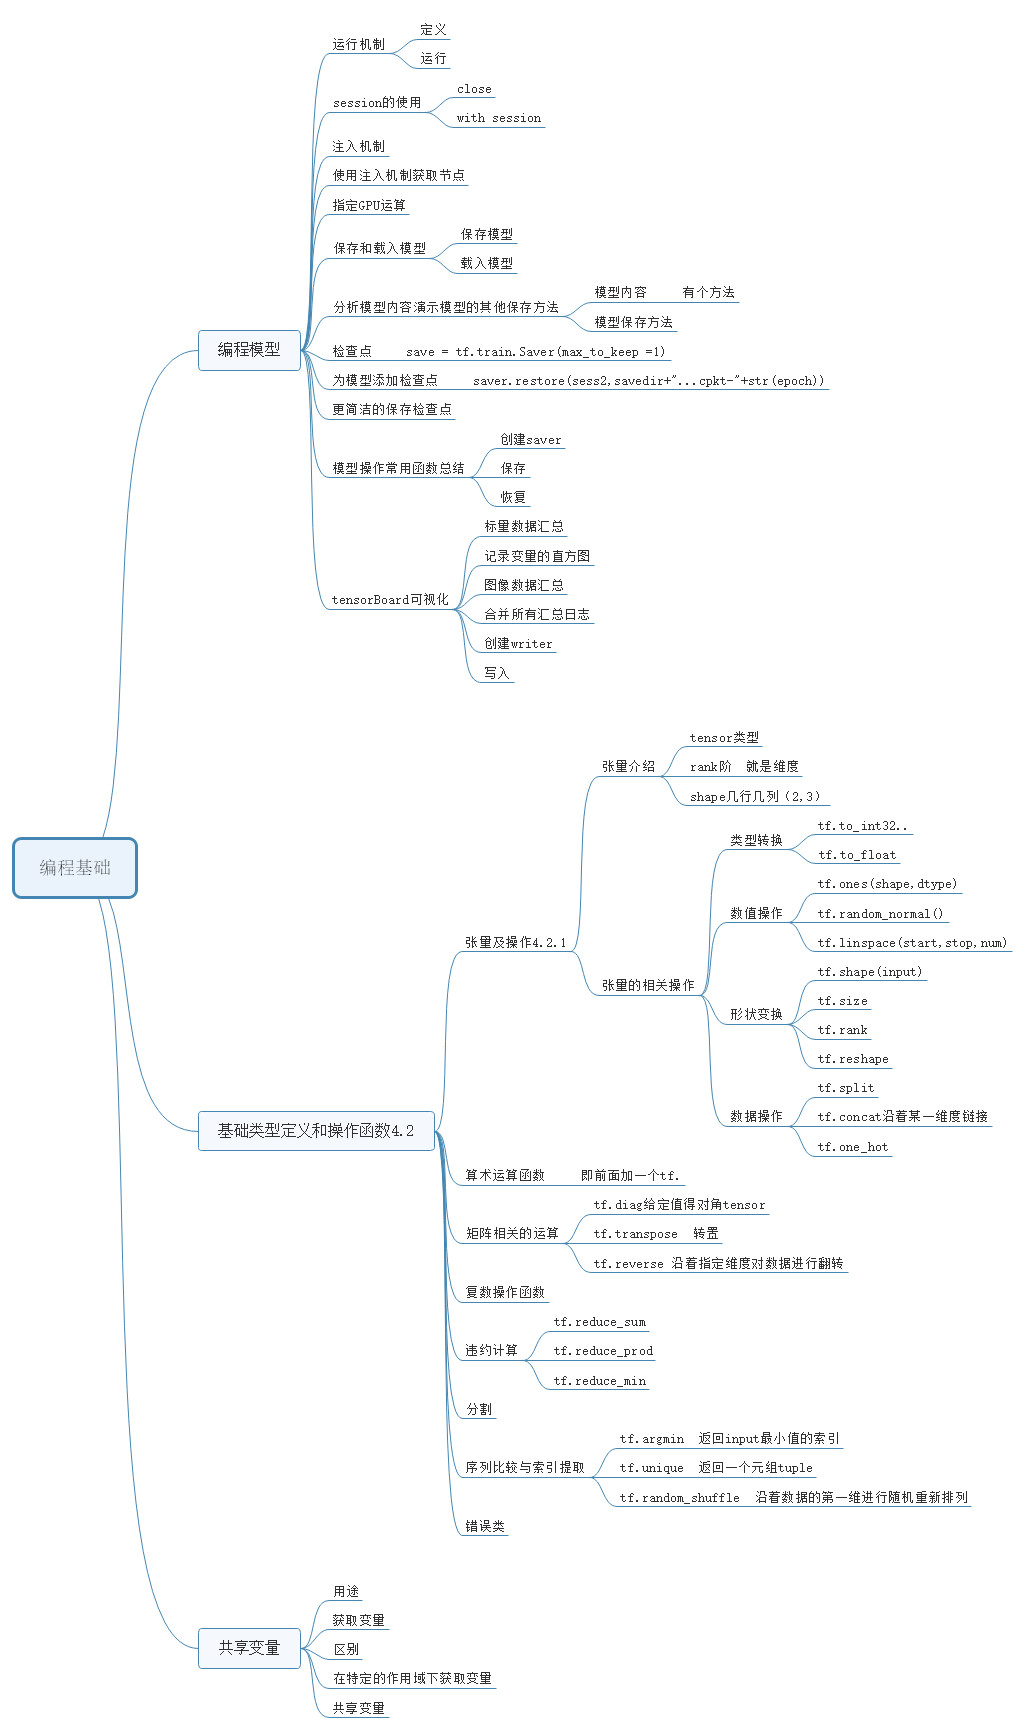
 